In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load datasets
integrate4 = pd.read_csv('integrate4.csv')
tass5 = pd.read_csv('tass5.csv')
diag3 = pd.read_csv('diag3.csv')
intheset = pd.read_csv('intheset.csv')
car36 = pd.read_csv('car36.csv')
all_close_treat = pd.read_csv('all_close_treat.csv')

# Filter and process integrate4 data
df = integrate4[['id', 'mydate', 'crisis_treat24', 'crisis_treat24_90', 'fund_closedxcrisis', 'div_corr', 'corr_eps']]
df = df.sort_values(by=['id', 'mydate']).drop_duplicates(subset=['id', 'mydate'])

# Handle div_corr > 0.985
df.loc[df['div_corr'] > 0.985, 'div_corr'] = np.nan

# Calculate mindate
df['mindate'] = df.groupby('id')['mydate'].transform('min')

# Merge with tass5
df = df.merge(tass5, on=['id', 'mydate'], how='left')

# Merge with diag3 to get pre_treat and other variables
df = df.merge(diag3, on='companyid', how='left')

# Create TREATED variable
df['TREATED'] = np.where((df['mydate'] > 593) & (df['mydate'] <= 617) & (df['pre_treat'] == 1), 1, 0)

# Merge with intheset
df = df.merge(intheset, on=['id', 'mydate'], how='left')

# Calculate additional variables
df['fundcounter_i'] = 1
df['missing_aum_firm'] = df['aum'].isna().astype(int)

# Aggregate firm-level data
firm_level_agg = df.groupby(['companyid', 'mydate']).agg({
    'aum': 'sum',
    'fundcounter_i': 'sum',
    'missing_aum_firm': 'max'
}).reset_index().rename(columns={
    'aum': 'aum_firm',
    'fundcounter_i': 'fundcounter_j'
})

firm_level_agg['log_firmscope'] = np.log(firm_level_agg['fundcounter_j'])

# Merge the firm-level data back to the original dataframe
df = df.merge(firm_level_agg, on=['companyid', 'mydate'], how='left')

df['age'] = df['mydate'] - df['mindate'] + 1
df['log_age'] = np.log(df['age'])

# Create deciles for aum and age
df['sz_dec'] = pd.qcut(df['aum'], 10, labels=False)
df['age_dec'] = pd.qcut(df['age'], 10, labels=False)

# Create size decile dummies
sz_q_dummies = pd.get_dummies(df['sz_dec'], prefix='sz_q')
df = pd.concat([df, sz_q_dummies], axis=1)

# Create post variable (assuming crisis ends at mydate 593)
df['post'] = np.where(df['mydate'] > 593, 1, 0)

# Handle missing aum
df['missing_aum'] = df['aum'].isna().astype(int)

# Calculate standardized variables and IR
df['stdv'] = df['stdv'].clip(df['stdv'].quantile(0.01), df['stdv'].quantile(0.99))
df['ir'] = df['excess_ret'] / df['stdv']
df['ir'] = df['ir'].clip(df['ir'].quantile(0.01), df['ir'].quantile(0.99))

df['excess_ret'] = df['excess_ret'].clip(df['excess_ret'].quantile(0.01), df['excess_ret'].quantile(0.99))

# Calculate scope quartiles
df['firmscope'] = np.exp(df['log_firmscope'])
df['scope_q1'] = np.where(df['firmscope'] <= df['firmscope'].quantile(0.25), 1, 0)
df['scope_q2'] = np.where(df['firmscope'].between(df['firmscope'].quantile(0.25), df['firmscope'].quantile(0.50)), 1, 0)
df['scope_q3'] = np.where(df['firmscope'].between(df['firmscope'].quantile(0.50), df['firmscope'].quantile(0.75)), 1, 0)
df['scope_q4'] = np.where(df['firmscope'] > df['firmscope'].quantile(0.75), 1, 0)

# Ensure mydate is a string and pad it to the correct length
df['mydate'] = df['mydate'].astype(str).str.pad(width=8, fillchar='0')

df['date'] = pd.to_datetime(df['date'])
# Create year variable
df['year'] = pd.to_datetime(df['date'], format='%Y%m%d').dt.year
# Ensure year_dum variables are correctly created
year_dummies = pd.get_dummies(df['year'], prefix='year_dum')
df = pd.concat([df, year_dummies], axis=1)

df['int1c'] = np.where(df['div_corr'].notna(), df['div_corr'] * df['TREATED'], 0)
df['ever_treated'] = df.groupby('id')['TREATED'].transform('max').astype(bool)
df['first30'] = np.where(df['ever_treated'] & df['mydate'].astype(int).between(594, 623), 1, 0)
df['second30'] = np.where(df['ever_treated'] & df['mydate'].astype(int).between(624, 653), 1, 0)
df['sz_dec'] = pd.qcut(df['aum_firm'], 10, labels=False)
firmsz_q_dummies = pd.get_dummies(df['sz_dec'], prefix='firmsz_q')
df = pd.concat([df, firmsz_q_dummies], axis=1)
# Create dummies for firm age deciles
df['firmage_q'] = pd.qcut(df['age'], 10, labels=False)
firmage_q_dummies = pd.get_dummies(df['firmage_q'], prefix='firmage_q')
df = pd.concat([df, firmage_q_dummies], axis=1)
df['age_dec'] = pd.qcut(df['age'], 10, labels=False)
age_q_dummies = pd.get_dummies(df['age_dec'], prefix='age_q')
df = pd.concat([df, age_q_dummies], axis=1)

tass7 = df.copy()

# Create firm-level data for fund-level analysis
df_firm_level = df[df['intheset'] == 1]
df_firm_level = df_firm_level[df_firm_level['firmscope'] < 50]
df_firm_level = df_firm_level.groupby(['companyid', 'mydate']).agg({
    'excess_ret': 'mean',
    'ret': 'mean',
    'post': 'mean',
    'aum': 'mean',
    'fundcounter_j': 'max',
    'TREATED': 'max',
    'age': 'max',
    **{col: 'mean' for col in year_dummies.columns},
    **{col: 'mean' for col in sz_q_dummies.columns}
}).reset_index()
df_firm_level['log_firmscope'] = np.log(df_firm_level['fundcounter_j'])
df_firm_level['log_firmage'] = np.log(df_firm_level['age'] + 1)
df_firm_level['age_dec'] = pd.qcut(df_firm_level['age'], 10, labels=False)
df_firm_level = pd.get_dummies(df_firm_level, columns=['age_dec'], prefix='firmage_q')
df_firm_level['stdv_firm'] = df_firm_level.groupby(['companyid', 'TREATED'])['excess_ret'].transform('std')
df_firm_level['firm_ir'] = df_firm_level['excess_ret'] / df_firm_level['stdv_firm']
df_firm_level = df_firm_level.rename(columns={'fundcounter_j': 'firm_scope', 'age': 'firm_age'})

tass8 = df_firm_level.copy()
# Fund-level analysis: Merge datasets
columns_to_merge_from_tass7 = ['companyid', 'mydate', 'TREATED','missing_aum', 'int1c', 'ever_treated', 'first30', 'second30', 'id', 'div_corr', 'fund_closedxcrisis','firmscope', 'intheset', 'scope_q1', 'scope_q2', 'scope_q3', 'scope_q4', 'aum', 'log_age',
                               'ir']
columns_to_merge_from_tass7.extend(firmsz_q_dummies.columns)  # Add the firmsize dummies
columns_to_merge_from_tass7.extend(firmage_q_dummies.columns) # Add the firmage dummies
columns_to_merge_from_tass7.extend(age_q_dummies.columns) # Add the firmage dummies

df_fund_level = tass8.merge(
    tass7[columns_to_merge_from_tass7], 
    on=['companyid', 'mydate'], 
    how='left'
)
# Ensure 'id' is present in car36
car36['id'] = car36['id'].astype(str)
df_fund_level['id'] = df_fund_level['id'].astype(str)

# Convert mydate in car36 to string for merging
car36['mydate'] = car36['mydate'].astype(str).str.pad(width=8, fillchar='0')
all_close_treat['mydate'] = all_close_treat['mydate'].astype(str).str.pad(width=8, fillchar='0')

df_fund_level = df_fund_level.merge(car36[['id', 'mydate']], on=['id', 'mydate'], how='left')
df_fund_level = df_fund_level.merge(all_close_treat[['companyid', 'mydate', 'all_close_treat']], on=['companyid', 'mydate'], how='left')
df_fund_level = df_fund_level.loc[:, ~df_fund_level.columns.duplicated()]

# Check if TREATED variable exists after merging steps
df_fund_level['TREATED'] = df_fund_level['TREATED_x']
df_fund_level['ALL_TREAT'] = df_fund_level['all_close_treat'] - df_fund_level['TREATED']
for i in tass7.columns:
    print(i)

id
mydate
crisis_treat24
crisis_treat24_90
fund_closedxcrisis
div_corr
corr_eps
mindate
date
ret
aum
companyid
Main Strategy
incentivefee
managementfee
year
month
maxmydate
minmydate
sporadic_dum
ret_star
Mkt-RF
SMB
HML
RF
PTFSBD
PTFSFX
PTFSCOM
Mom
DBAA
DGS10
lhs
excess_ret
beta1
beta2
beta3
beta4
beta5
beta6
beta7
alpha
stdv
r2
pre_treat
TREATED
intheset
intheset2
fundcounter_i
missing_aum_firm_x
aum_firm
fundcounter_j
missing_aum_firm_y
log_firmscope
age
log_age
sz_dec
age_dec
sz_q_0
sz_q_1
sz_q_2
sz_q_3
sz_q_4
sz_q_5
sz_q_6
sz_q_7
sz_q_8
sz_q_9
post
missing_aum
ir
firmscope
scope_q1
scope_q2
scope_q3
scope_q4
year_dum_1996
year_dum_1997
year_dum_1998
year_dum_1999
year_dum_2000
year_dum_2001
year_dum_2002
year_dum_2003
year_dum_2004
year_dum_2005
year_dum_2006
year_dum_2007
year_dum_2008
year_dum_2009
year_dum_2010
year_dum_2011
int1c
ever_treated
first30
second30
firmsz_q_0
firmsz_q_1
firmsz_q_2
firmsz_q_3
firmsz_q_4
firmsz_q_5
firmsz_q_6
firmsz_q_7
firmsz_q_8
firmsz_q_9
firmage_q


REG1 part 2

In [12]:
df_fund_level['ALL_TREAT'] = df_fund_level['all_close_treat'] - df_fund_level['TREATED']
df_fund_level['ALL_TREAT'] = df_fund_level['ALL_TREAT'].clip(lower=0)

df_fund_level['time_treat'] = df_fund_level['mydate'].astype(int) - 594
df_fund_level['int2'] = df_fund_level['TREATED'] * df_fund_level['time_treat']
df_fund_level['int3'] = df_fund_level['ALL_TREAT'] * df_fund_level['time_treat']
df_fund_level['int3'] = df_fund_level['int3'].fillna(0)

df_fund_level['max_treated'] = df_fund_level.groupby('id')['TREATED'].transform('max')
df_fund_level['max_treated'] = np.where(df_fund_level['mydate'].astype(int) < 594, 0, df_fund_level['max_treated'])

df_fund_level['first24'] = np.where(df_fund_level['mydate'].astype(int).between(594, 617), 1, 0)
df_fund_level['next36'] = np.where(df_fund_level['mydate'].astype(int) > 617, 1, 0)

df_fund_level['Tx24'] = df_fund_level['max_treated'] * df_fund_level['first24']
df_fund_level['Txn36'] = df_fund_level['max_treated'] * df_fund_level['next36']

df_fund_level['max_int1c'] = df_fund_level.groupby('id')['int1c'].transform('max')
df_fund_level['max_int1c'] = np.where(df_fund_level['mydate'].astype(int) < 594, 0, df_fund_level['max_int1c'])

df_fund_level['max_int2'] = df_fund_level.groupby('id')['int2'].transform('max')
df_fund_level['max_int2'] = np.where(df_fund_level['mydate'].astype(int) < 594, 0, df_fund_level['max_int2'])

df_fund_level['Tx24xrelated'] = df_fund_level['Tx24'] * df_fund_level['max_int1c']
df_fund_level['Txn36xrelated'] = df_fund_level['Txn36'] * df_fund_level['max_int1c']

df_fund_level['triple_int'] = np.where(df_fund_level['div_corr'].notna(), df_fund_level['TREATED'] * df_fund_level['time_treat'] * df_fund_level['div_corr'], 0)
df_fund_level['int1c_max'] = np.where(df_fund_level['div_corr'].notna(), df_fund_level['max_treated'] * df_fund_level['div_corr'], 0)
df_fund_level['int2_max'] = df_fund_level['max_treated'] * df_fund_level['time_treat']
df_fund_level['triple_int_max'] = np.where(df_fund_level['div_corr'].notna(), df_fund_level['max_treated'] * df_fund_level['time_treat'] * df_fund_level['div_corr'], 0)

df_fund_level['max_firmscope'] = df_fund_level.groupby('companyid')['firmscope'].transform('max')
median_max_firmscope = df_fund_level.loc[(df_fund_level['max_treated'] == 1) & (df_fund_level['intheset'] == 1) & (df_fund_level['firmscope'] < 50), 'max_firmscope'].median()

df_fund_level.to_csv('tass12.csv', index=False)

# Summary statistics
summary_stats = df_fund_level[(df_fund_level['intheset'] == 1) & (df_fund_level['mydate'].astype(int) <= 617) & (df_fund_level['firmscope'] < 50)].describe()
summary_stats.to_csv('summary_stats.csv')

# # Function to add missing dummy variables
# def add_missing_dummies(df, prefix, n):
#     for i in range(n):
#         col_name = f"{prefix}{i}"
#         if col_name not in df.columns:
#             df[col_name] = 0
#     return df

# # Ensure all dummy variables are present
# df_fund_level = add_missing_dummies(df_fund_level, 'sz_q', 10)
# df_fund_level = add_missing_dummies(df_fund_level, 'scope_q', 5)
# df_fund_level = add_missing_dummies(df_fund_level, 'age_q', 10)
# df_fund_level = add_missing_dummies(df_fund_level, 'firmsz_q', 10)
# df_fund_level = add_missing_dummies(df_fund_level, 'firmage_q', 10)
# df_fund_level = add_missing_dummies(df_fund_level, 'year_dum_', 19)  # 1994 to 2012

# Basic IR Results
# Convert categorical variables to strings for patsy formula
# df_fund_level['sz_q'] = df_fund_level['sz_q'].astype(str)
# df_fund_level['scope_q'] = df_fund_level['scope_q'].astype(str)
# df_fund_level['age_q'] = df_fund_level['age_q'].astype(str)
# df_fund_level['firmsz_q'] = df_fund_level['firmsz_q'].astype(str)
# df_fund_level['firmage_q'] = df_fund_level['firmage_q'].astype(str)

# Basic IR Results

# Filter the dataframe for the regression
regression_df = df_fund_level[(df_fund_level['intheset'] == 1) & (df_fund_level['mydate'].astype(int) <= 617) & (df_fund_level['firmscope'] < 50)]

# for i in range(10):
#     regression_df[f'sz_q{i}'] = regression_df[f'sz_q_{i}']
#     regression_df[f'age_q{i}'] = int(regression_df[f'age_q_{i}']==0) 
#     regression_df[f'firmsz_q{i}'] = int(regression_df[f'firmsz_q_{i}.0'] == 0)
#     regression_df[f'firmage_q{i}'] = int(regression_df[f'firmage_q_{i}_y'] == 0)

for i in range(10):
    regression_df[f'sz_q{i}'] = regression_df[f'sz_q_{i}']
    regression_df[f'age_q{i}'] = (regression_df[f'age_q_{i}']) 
    regression_df[f'firmsz_q{i}'] = (regression_df[f'firmsz_q_{i}'])
    regression_df[f'firmage_q{i}'] = (regression_df[f'firmage_q_{i}_y'])

# Minimal regression model
# 1. Drop unnecessary dummy variables 
# Assuming you have dummy variables like sz_q0, sz_q1, ..., sz_q9, keep only sz_q1 to sz_q9
# regression_df = regression_df.drop(columns=['sz_q0'])  # Similarly drop first dummy for other categorical variables

# 2. Handling Missing Values
# Impute or drop missing values in the relevant columns
regression_df.dropna(subset=['ir', 'TREATED'] + [col for col in regression_df.columns if col.startswith(('sz_q', 'scope_q', 'age_q', 'firmsz_q', 'firmage_q', 'year_dum_'))], inplace=True)

# 3. Filtering for clustering
# Ensure groups have at least two observations
id_counts = regression_df['id'].value_counts()
regression_df = regression_df[regression_df['id'].isin(id_counts[id_counts > 1].index)]

# Double-check and convert 'id' to numeric if needed
regression_df['id'] = pd.to_numeric(regression_df['id']) 

# 4. Reset the index after filtering
regression_df = regression_df.reset_index(drop=True)
regression_df.to_csv('regression_df.csv')

In [13]:
regression_df


,companyid,mydate,excess_ret,ret,post,aum_x,firm_scope,TREATED_x,firm_age,year_dum_1996,...,firmsz_q7,firmage_q7,sz_q8,age_q8,firmsz_q8,firmage_q8,sz_q9,age_q9,firmsz_q9,firmage_q9
0,66,00000595,10.743529,0.063199,1.0,6.953126e+08,1,0,144,0.0,...,False,False,0.0,False,False,False,0.0,True,False,True
1,66,00000596,10.723928,0.042599,1.0,7.359728e+08,1,0,145,0.0,...,False,False,0.0,False,False,False,0.0,True,False,True
2,66,00000597,10.684042,-0.052399,1.0,6.506064e+08,1,0,146,0.0,...,False,False,0.0,False,False,False,0.0,True,False,True
3,66,00000598,10.707844,0.009099,1.0,6.893713e+08,1,0,147,0.0,...,False,False,0.0,False,False,False,0.0,True,False,True
4,66,00000599,10.729190,0.061999,1.0,7.140185e+08,1,0,148,0.0,...,False,False,0.0,False,False,False,0.0,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,43195,00000613,-5.182098,0.034800,1.0,1.290000e+10,1,0,57,0.0,...,False,False,0.0,False,True,False,1.0,False,False,False
879,43195,00000614,-5.194001,-0.008100,1.0,1.280000e+10,1,0,58,0.0,...,False,False,0.0,False,True,False,1.0,False,False,False
880,43195,00000615,-5.156188,0.059700,1.0,1.280000e+10,1,0,59,0.0,...,False,False,0.0,False,True,False,1.0,False,False,False
881,43195,00000616,-5.203192,-0.031700,1.0,1.380000e+10,1,0,60,0.0,...,False,False,0.0,False,True,False,1.0,False,False,False


In [14]:
# List of columns to keep
columns_to_keep = ['ir', 'TREATED', 'intheset'] + \
                  [f'sz_q{i}' for i in range(10)] + \
                  [f'scope_q{i}' for i in range(1, 5)] + \
                  [f'age_q{i}' for i in range(10)] + \
                  [f'firmsz_q{i}' for i in range(10)] + \
                  [f'firmage_q{i}' for i in range(10)] + \
                  [f'year_dum_{i}' for i in range(1994, 2012)]

# Select the specified columns from the dataframe
selected_data = regression_df[columns_to_keep]

# Save the new dataset to a CSV file
selected_data.to_csv('pure_regression.csv', index=False)

KeyError: "['year_dum_1994', 'year_dum_1995'] not in index"

In [15]:
selected_data

,ir,TREATED,intheset,sz_q0,sz_q1,sz_q2,sz_q3,sz_q4,sz_q5,sz_q6,...,year_dum_2002,year_dum_2003,year_dum_2004,year_dum_2005,year_dum_2006,year_dum_2007,year_dum_2008,year_dum_2009,year_dum_2010,year_dum_2011
0,0.662834,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.665875,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.662104,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.666566,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.664532,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44124,-1.539360,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44125,-1.539185,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44126,-1.539286,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44127,-1.540925,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe with the independent variables
X = regression_df[['TREATED'] + [f'sz_q{i}' for i in range(10)] + [f'scope_q{i}' for i in range(1, 5)] 
                   + [f'year_dum_{i}' for i in range(1994, 2008)]+[f'year_dum_{i}' for i in range(2009, 2012)]]

# Add a constant
X = sm.add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


KeyError: "['year_dum_1994', 'year_dum_1995'] not in index"

In [22]:
# Basic IR Results
model = smf.ols('ir ~ TREATED +' + ' + '  .join([f'sz_q{i}' for i in range(10)])+ ' + ' +
                ' + '.join([f'age_q{i}' for i in range(10)])+ ' + ' +
                ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                ' + '.join([f'firmsz_q{i}' for i in range(10)]) + ' + ' +
                ' + '.join([f'firmage_q{i}' for i in range(10)]) + ' + ' +

                ' + '.join([f'year_dum_{i}' for i in range(1996, 2008)])+ ' + ' +
                ' + '.join([f'year_dum_{i}' for i in range(2009, 2012)]),data=regression_df).fit(cov_type='cluster', cov_kwds={'groups': regression_df['id']})

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     ir   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                 5.293e-14
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               1.00
Time:                        14:21:52   Log-Likelihood:                -1491.6
No. Observations:                 883   AIC:                             3069.
Df Residuals:                     840   BIC:                             3275.
Df Model:                          42                                         
Covariance Type:              cluster                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0483      0

/Users/hendrik/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 60, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/hendrik/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1885: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


0


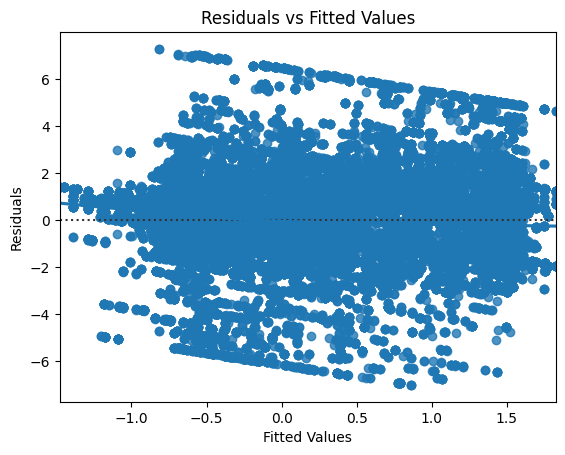

In [18]:
print(regression_df.duplicated().sum())
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting residuals vs fitted values
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()


In [19]:


# Additional regressions as needed
# Regression model with absorb(id)
model_absorb = smf.ols('ir ~ TREATED + ' +
                       ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                       ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                       # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                       # ' + '.join([f'firmsz_q{i}' for i in range(10)]) + ' + ' +
                       # ' + '.join([f'firmage_q{i}' for i in range(10)]) + ' + ' +
                       ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                       data=regression_df[(regression_df['intheset'] == 1) & (regression_df['mydate'].astype(int) <= 617) & (regression_df['firmscope'] < 50)]).fit(cov_type='cluster', cov_kwds={'groups': regression_df['id']})

print(model_absorb.summary())

# Save model results
with open('model_absorb_results.txt', 'w') as f:
    f.write(model_absorb.summary().as_text())

# Additional analyses and summary statistics
regression_df['median_rel_int'] = 0
regression_df['median_rel_int'] = regression_df['int1c'].where(regression_df['int1c'] >= regression_df['int1c'].median(), 0)
regression_df['median_rel_int'] = regression_df['median_rel_int'].where(regression_df['int1c'] < regression_df['int1c'].median(), 1)

regression_df['intheset2'] = regression_df['intheset'].where(regression_df['median_rel_int'] == 1, 0)
regression_df['intheset3'] = regression_df['intheset'].where(regression_df['median_rel_int'] == 0, 0)

model_rel_int = smf.ols('ir ~ max_treated + time_treat + ' +
                        ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                        ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                        # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                        # ' + '.join([f'firmsz_q{i}' for i in range(10)]) + ' + ' +
                        # ' + '.join([f'firmage_q{i}' for i in range(10)]) + ' + ' +
                        ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                        data=regression_df[(regression_df['intheset2'] == 1) & (regression_df['firmscope'] < 50)]).fit(cov_type='cluster', cov_kwds={'groups': regression_df['id']})

print(model_rel_int.summary())
with open('model_rel_int_results.txt', 'w') as f:
    f.write(model_rel_int.summary().as_text())
##########################################################################################################################################################################
# Create grouped object for clustering BEFORE filtering
grouped = regression_df.groupby('id')

# Regressions for additional analysis
# Model for "related" firms with firmscope < 50
filtered_related = grouped.filter(lambda x: len(x) >= 2 and (x['intheset2'] == 1).any() and (x['firmscope'] < 50).all())  # Filter within groups
model_rel_int = smf.ols('ir ~ max_treated + time_treat + ' +
                        ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                        ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                        # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                        # ' + '.join([f'firmsz_q{i}' for i in range(1, 10)]) + ' + ' +
                        # ' + '.join([f'firmage_q{i}' for i in range(1, 10)]) + ' + ' +
                        ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                        data=filtered_related).fit(cov_type='cluster', cov_kwds={'groups': filtered_related['id']})
print(model_rel_int.summary())
with open('model_rel_int_results.txt', 'w') as f:
    f.write(model_rel_int.summary().as_text())

# Subsample regressions
median_max_firmscope = regression_df[(regression_df['max_treated'] == 1) & (regression_df['intheset'] == 1) & (regression_df['firmscope'] < 50)]['max_firmscope'].median()

# Model: firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + controls (firmscope < median)
filtered_low_scope = grouped.filter(lambda x: len(x) >= 2 and (x['max_firmscope'] < median_max_firmscope).all())
model_subsample_review_1 = smf.ols('firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + ' +
                                   ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                                   # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmsz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmage_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                                   data=filtered_low_scope).fit(cov_type='cluster', cov_kwds={'groups': filtered_low_scope['id']})
print(model_subsample_review_1.summary())
with open('model_subsample_review_1_results.txt', 'w') as f:
    f.write(model_subsample_review_1.summary().as_text())

# Model: firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + controls (firmscope >= median)
filtered_high_scope = grouped.filter(lambda x: len(x) >= 2 and (x['max_firmscope'] >= median_max_firmscope).all())
model_subsample_review_2 = smf.ols('firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + ' +
                                   ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                                   # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmsz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmage_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                                   data=filtered_high_scope).fit(cov_type='cluster', cov_kwds={'groups': filtered_high_scope['id']})
print(model_subsample_review_2.summary())
with open('model_subsample_review_2_results.txt', 'w') as f:
    f.write(model_subsample_review_2.summary().as_text())
# Save model results

########################################################################################################################################

# Additional preparations for the regressions and final steps of reg1.do
# Subsample regressions as called for by reviewer
model_subsample_review_1 = smf.ols('firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + ' +
                                   ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                                   # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmsz_q{i}' for i in range(10)]) + ' + ' +
                                   # ' + '.join([f'firmage_q{i}' for i in range(10)]) + ' + ' +
                                   ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                                   data=regression_df[regression_df['max_firmscope'] < median_max_firmscope]).fit(cov_type='cluster', cov_kwds={'groups': regression_df['id']})
print(model_subsample_review_1.summary())
with open('model_subsample_review_1_results.txt', 'w') as f:
    f.write(model_subsample_review_1.summary().as_text())

model_subsample_review_2 = smf.ols('firm_ir ~ max_treated + int1c_max + int2_max + triple_int_max + ' +
                                   ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                                   ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                                   # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                                   # ' + '.join([f'firmsz_q{i}' for i in range(10)]) + ' + ' +
                                   # ' + '.join([f'firmage_q{i}' for i in range(10)]) + ' + ' +
                                   ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                                   data=regression_df[regression_df['max_firmscope'] >= median_max_firmscope]).fit(cov_type='cluster', cov_kwds={'groups': regression_df['id']})
print(model_subsample_review_2.summary())
with open('model_subsample_review_2_results.txt', 'w') as f:
    f.write(model_subsample_review_2.summary().as_text())


PatsyError: Error evaluating factor: NameError: name 'year_dum_1994' is not defined
    ir ~ TREATED + sz_q1 + sz_q2 + sz_q3 + sz_q4 + sz_q5 + sz_q6 + sz_q7 + sz_q8 + sz_q9 + scope_q1 + scope_q2 + scope_q3 + scope_q4 + year_dum_1994 + year_dum_1995 + year_dum_1996 + year_dum_1997 + year_dum_1998 + year_dum_1999 + year_dum_2000 + year_dum_2001 + year_dum_2002 + year_dum_2003 + year_dum_2004 + year_dum_2005 + year_dum_2006 + year_dum_2007 + year_dum_2008 + year_dum_2009 + year_dum_2010 + year_dum_2011
                                                                                                                                       ^^^^^^^^^^^^^